# Design 1 without pre-trained weights

Here we experiment with our model being trained with basic initialization.

# Loading Requirements

In [1]:
from collections import Counter, defaultdict
from IPython import display
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
from torch import nn, optim
from torch.autograd import Variable
from torchvision import models, transforms
from random import shuffle

import json
import matplotlib
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
import torchvision
import os

# Prepocessing

The following code preprocesses the data, collecting the image array as needed and preparing for ANP classifying.

In [2]:
vso_images_folder = "data/vso/vso_images_with_cc/"

train_anp_tags = []
train_image_addresses = []
train_image_to_anp_tag = {}
for subdir in os.listdir(vso_images_folder):
    if subdir.endswith("_train"):
        train_anp_tags.append(subdir.replace("_train", "").replace("_", " "))
        for filename in os.listdir(vso_images_folder + subdir):
            if filename.endswith(".jpg"):
                train_image_addresses.append(vso_images_folder + subdir + "/"  + filename)
                train_image_to_anp_tag[vso_images_folder + subdir + "/"  + filename] = subdir.replace("_train", "").replace("_", " ")

validation_anp_tags = []
validation_image_addresses = []
validation_image_to_anp_tag = {}
for subdir in os.listdir(vso_images_folder):
        if subdir.endswith("_validation"):
                validation_anp_tags.append(subdir.replace("_validation", "").replace("_", " "))
                for filename in os.listdir(vso_images_folder + subdir):
                        if filename.endswith(".jpg"):
                                validation_image_addresses.append(vso_images_folder + subdir + "/"  + filename)
                                validation_image_to_anp_tag[vso_images_folder + subdir + "/"  + filename] = subdir.replace("_validation", "").replace("_", " ")

test_anp_tags = []
test_image_addresses = []
test_image_to_anp_tag = {}
for subdir in os.listdir(vso_images_folder):
        if subdir.endswith("_test"):
                test_anp_tags.append(subdir.replace("_test", "").replace("_", " "))
                for filename in os.listdir(vso_images_folder + subdir):
                        if filename.endswith(".jpg"):
                                test_image_addresses.append(vso_images_folder + subdir + "/"  + filename)
                                test_image_to_anp_tag[vso_images_folder + subdir + "/"  + filename] = subdir.replace("_test", "").replace("_", " ")

anp_tag_to_vector = {}
for i, tag in enumerate(train_anp_tags):
    anp_vector = np.zeros(len(train_anp_tags))
    anp_vector[i] = 1
    anp_tag_to_vector[tag] = anp_vector
    
# randomizing order of the examples
shuffle(train_image_addresses)
shuffle(validation_image_addresses)
shuffle(test_image_addresses)
                                
print("Number of train images: ", len(train_image_to_anp_tag))
print("Number of validation images: ", len(validation_image_to_anp_tag))
print("Number of test images: ", len(test_image_to_anp_tag))
    
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
])

def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the images.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    return image_var.cuda()

#print(load_image('data/vso/vso_images_with_cc/amazing_flowers/1066918516_e27cbf795e.jpg'))

Number of train images:  336630
Number of validation images:  72352
Number of test images:  72340


# Sample Data Points

Showing a few examples of the sample data points.

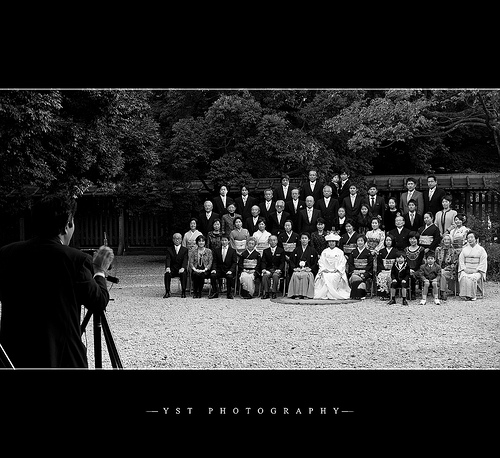

Image:  data/vso/vso_images_with_cc/traditional_wedding_train/5400402131_b6b53c8dbb.jpg
Associated ANP tag:  traditional wedding


In [3]:
display.display(display.Image(train_image_addresses[0]))
print("Image: ", train_image_addresses[0])
print("Associated ANP tag: ", train_image_to_anp_tag[train_image_addresses[0]])

# Model Defition

The following define the model used for the ANP classifier.

In [4]:
class ANPClassifier(nn.Module):
    def __init__(self, output_size):
        super(ANPClassifier, self).__init__()
        
        self.output_size = output_size
        self.resnet = torchvision.models.resnet101(pretrained=False)
        self.resnet.fc = nn.Linear(in_features=2048, out_features=output_size, bias=True)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        return self.log_softmax(self.resnet(X))

main_model = ANPClassifier(len(train_anp_tags))
main_model

ANPClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): 

# Training

Following describes training procedure used to form the ANP classifier.

In [5]:
USE_CUDA = True # switch to true when training on GPU(s)

def train_pass(image_input, target_output, model, optimizer, criterion):
    """
    Given batch of images, completes one pass of training on the model,
    using the given optimizer and criterion.
    """

    if USE_CUDA:
        image_input = image_input.cuda()
        target_output = target_output.cuda()
        model = model.cuda()
        criterion = criterion.cuda()

    optimizer.zero_grad()
    model_output = model(image_input)
    
    loss = criterion(model_output, target_output)
    loss.backward()
    optimizer.step()

    return loss.data.cpu().numpy()

def load_batch(image_addresses, volatile=False):
    
    img_tensor = load_image(image_addresses[0])
    for i in range(1, len(image_addresses)):
        img_tensor = torch.cat((img_tensor, load_image(image_addresses[i])))
        
    target_tensor = torch.from_numpy(anp_tag_to_vector[train_image_to_anp_tag[image_addresses[0]]]).unsqueeze(0)
    for i in range(1, len(image_addresses)):
        target_tensor = torch.cat((target_tensor, torch.from_numpy(anp_tag_to_vector[train_image_to_anp_tag[image_addresses[i]]]).unsqueeze(0)))
        
    target_indices = torch.argmax(target_tensor, 1)
        
    return img_tensor, target_indices

def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)

train(main_model)

Done Batch: 0 	Average Loss Per Batch: 7.6471781730651855 	 Current Batch Loss:  7.647178
Done Batch: 50 	Average Loss Per Batch: 7.2824063768573835 	 Current Batch Loss:  7.3618574
Done Batch: 100 	Average Loss Per Batch: 7.173195565100944 	 Current Batch Loss:  7.035472
Done Batch: 150 	Average Loss Per Batch: 7.111777684546464 	 Current Batch Loss:  7.079618
Done Batch: 200 	Average Loss Per Batch: 7.067351770638234 	 Current Batch Loss:  7.0172553
Done Batch: 250 	Average Loss Per Batch: 7.039838709204321 	 Current Batch Loss:  6.934287
Done Batch: 300 	Average Loss Per Batch: 7.010447584513414 	 Current Batch Loss:  6.7635217
Done Batch: 350 	Average Loss Per Batch: 6.991123708904299 	 Current Batch Loss:  6.769773
Done Batch: 400 	Average Loss Per Batch: 6.973582628064619 	 Current Batch Loss:  6.969829
Done Batch: 450 	Average Loss Per Batch: 6.952198602672162 	 Current Batch Loss:  6.747315
Done Batch: 500 	Average Loss Per Batch: 6.9339071547913695 	 Current Batch Loss:  6.667

Done Batch: 1050 	Average Loss Per Batch: 6.281436174285627 	 Current Batch Loss:  6.144527
Done Batch: 1100 	Average Loss Per Batch: 6.278715153589344 	 Current Batch Loss:  6.046143
Done Batch: 1150 	Average Loss Per Batch: 6.2776065361593 	 Current Batch Loss:  6.2965627
Done Batch: 1200 	Average Loss Per Batch: 6.275304093547507 	 Current Batch Loss:  6.3214307
Done Batch: 1250 	Average Loss Per Batch: 6.2735538520782494 	 Current Batch Loss:  6.121847
Done Batch: 1300 	Average Loss Per Batch: 6.271409780222301 	 Current Batch Loss:  6.1027055
Done Batch: 1350 	Average Loss Per Batch: 6.269823248698745 	 Current Batch Loss:  5.9896355
Done Batch: 1400 	Average Loss Per Batch: 6.2681535238202 	 Current Batch Loss:  6.2343726
Done Batch: 1450 	Average Loss Per Batch: 6.266797699655523 	 Current Batch Loss:  6.106239
Done Batch: 1500 	Average Loss Per Batch: 6.264650282265741 	 Current Batch Loss:  6.057255
Done Batch: 1550 	Average Loss Per Batch: 6.261775876690233 	 Current Batch Lo

Done Batch: 2100 	Average Loss Per Batch: 6.029427861327616 	 Current Batch Loss:  6.003984
Done Batch: 2150 	Average Loss Per Batch: 6.0276275077901404 	 Current Batch Loss:  6.195223
Done Batch: 2200 	Average Loss Per Batch: 6.026201599784896 	 Current Batch Loss:  6.202009
Done Batch: 2250 	Average Loss Per Batch: 6.025190878316912 	 Current Batch Loss:  5.7468195
Done Batch: 2300 	Average Loss Per Batch: 6.024236372168921 	 Current Batch Loss:  6.0411515
Done Batch: 2350 	Average Loss Per Batch: 6.022455647872996 	 Current Batch Loss:  5.8472114
Done Batch: 2400 	Average Loss Per Batch: 6.02219482681643 	 Current Batch Loss:  5.711481
Done Batch: 2450 	Average Loss Per Batch: 6.021558161805183 	 Current Batch Loss:  6.008732
Done Batch: 2500 	Average Loss Per Batch: 6.020369179484273 	 Current Batch Loss:  6.4107466
Done Batch: 2550 	Average Loss Per Batch: 6.019344134500848 	 Current Batch Loss:  6.0176005
Done Batch: 2600 	Average Loss Per Batch: 6.017780049678593 	 Current Batch

Done Batch: 3100 	Average Loss Per Batch: 5.839994774676645 	 Current Batch Loss:  6.018997
Done Batch: 3150 	Average Loss Per Batch: 5.839056444485881 	 Current Batch Loss:  5.6961446
Done Batch: 3200 	Average Loss Per Batch: 5.837871516059987 	 Current Batch Loss:  5.7245784
Done Batch: 3250 	Average Loss Per Batch: 5.8370295252956925 	 Current Batch Loss:  5.507179
Done Batch: 3300 	Average Loss Per Batch: 5.8362800210434465 	 Current Batch Loss:  5.859494
Done Batch: 3350 	Average Loss Per Batch: 5.834877953462478 	 Current Batch Loss:  5.584882
Epoch: 3 	Time: 4398.199915647507 	Average Loss Per Batch:: 5.834192319903417
Done Batch: 0 	Average Loss Per Batch: 5.916414260864258 	 Current Batch Loss:  5.9164143
Done Batch: 50 	Average Loss Per Batch: 5.76361515007767 	 Current Batch Loss:  6.001273
Done Batch: 100 	Average Loss Per Batch: 5.775376673972253 	 Current Batch Loss:  5.8668504
Done Batch: 150 	Average Loss Per Batch: 5.761416700502105 	 Current Batch Loss:  5.6983857
Don

Done Batch: 700 	Average Loss Per Batch: 5.587189920618599 	 Current Batch Loss:  5.5619273
Done Batch: 750 	Average Loss Per Batch: 5.586388014604185 	 Current Batch Loss:  5.9697566
Done Batch: 800 	Average Loss Per Batch: 5.58714642209209 	 Current Batch Loss:  5.6977587
Done Batch: 850 	Average Loss Per Batch: 5.587752211668237 	 Current Batch Loss:  5.6113567
Done Batch: 900 	Average Loss Per Batch: 5.587942937370411 	 Current Batch Loss:  5.5395536
Done Batch: 950 	Average Loss Per Batch: 5.590093440688622 	 Current Batch Loss:  5.5603814
Done Batch: 1000 	Average Loss Per Batch: 5.587761831807566 	 Current Batch Loss:  5.4966087
Done Batch: 1050 	Average Loss Per Batch: 5.586335158143919 	 Current Batch Loss:  5.4824853
Done Batch: 1100 	Average Loss Per Batch: 5.584060575396879 	 Current Batch Loss:  5.486878
Done Batch: 1150 	Average Loss Per Batch: 5.584007882947615 	 Current Batch Loss:  5.6090107
Done Batch: 1200 	Average Loss Per Batch: 5.5827368070044985 	 Current Batch L

Done Batch: 1750 	Average Loss Per Batch: 5.385182830281152 	 Current Batch Loss:  5.389167
Done Batch: 1800 	Average Loss Per Batch: 5.38515687902261 	 Current Batch Loss:  5.3936267
Done Batch: 1850 	Average Loss Per Batch: 5.385335028847767 	 Current Batch Loss:  5.7184463
Done Batch: 1900 	Average Loss Per Batch: 5.382867391958543 	 Current Batch Loss:  5.229538
Done Batch: 1950 	Average Loss Per Batch: 5.38001173963796 	 Current Batch Loss:  5.350504
Done Batch: 2000 	Average Loss Per Batch: 5.377775047374689 	 Current Batch Loss:  5.314693
Done Batch: 2050 	Average Loss Per Batch: 5.3765620680799255 	 Current Batch Loss:  5.2559485
Done Batch: 2100 	Average Loss Per Batch: 5.3752946939881445 	 Current Batch Loss:  5.169223
Done Batch: 2150 	Average Loss Per Batch: 5.373664171404198 	 Current Batch Loss:  5.5708575
Done Batch: 2200 	Average Loss Per Batch: 5.372705290177799 	 Current Batch Loss:  5.6480947
Done Batch: 2250 	Average Loss Per Batch: 5.372012588089173 	 Current Batch

Done Batch: 2750 	Average Loss Per Batch: 5.112200354281793 	 Current Batch Loss:  4.928212
Done Batch: 2800 	Average Loss Per Batch: 5.1096277107557455 	 Current Batch Loss:  5.0783787
Done Batch: 2850 	Average Loss Per Batch: 5.1073211071492075 	 Current Batch Loss:  4.7449136
Done Batch: 2900 	Average Loss Per Batch: 5.105879451603118 	 Current Batch Loss:  4.8449874
Done Batch: 2950 	Average Loss Per Batch: 5.103134347559516 	 Current Batch Loss:  4.9000664
Done Batch: 3000 	Average Loss Per Batch: 5.100104916854447 	 Current Batch Loss:  4.950322
Done Batch: 3050 	Average Loss Per Batch: 5.097839063677543 	 Current Batch Loss:  5.064925
Done Batch: 3100 	Average Loss Per Batch: 5.094728686508922 	 Current Batch Loss:  5.101854
Done Batch: 3150 	Average Loss Per Batch: 5.0917880644839135 	 Current Batch Loss:  4.7219114
Done Batch: 3200 	Average Loss Per Batch: 5.089696929142722 	 Current Batch Loss:  4.858559
Done Batch: 3250 	Average Loss Per Batch: 5.087564183249542 	 Current Ba

Done Batch: 350 	Average Loss Per Batch: 4.576333961595497 	 Current Batch Loss:  4.0876145
Done Batch: 400 	Average Loss Per Batch: 4.565685900072207 	 Current Batch Loss:  3.9997845
Done Batch: 450 	Average Loss Per Batch: 4.5501855736032555 	 Current Batch Loss:  4.595671
Done Batch: 500 	Average Loss Per Batch: 4.54506088302521 	 Current Batch Loss:  4.550986
Done Batch: 550 	Average Loss Per Batch: 4.540461335987015 	 Current Batch Loss:  4.2890186
Done Batch: 600 	Average Loss Per Batch: 4.542407027100168 	 Current Batch Loss:  4.534943
Done Batch: 650 	Average Loss Per Batch: 4.54712948454873 	 Current Batch Loss:  4.6340957
Done Batch: 700 	Average Loss Per Batch: 4.552110576085459 	 Current Batch Loss:  4.4450355
Done Batch: 750 	Average Loss Per Batch: 4.551687348539756 	 Current Batch Loss:  4.792299
Done Batch: 800 	Average Loss Per Batch: 4.5470791961369885 	 Current Batch Loss:  4.7554865
Done Batch: 850 	Average Loss Per Batch: 4.5439021105491735 	 Current Batch Loss:  4

In [6]:
def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(10, 10 + epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)
    
train(main_model, epochs=5)

Done Batch: 0 	Average Loss Per Batch: 4.089768886566162 	 Current Batch Loss:  4.089769
Done Batch: 50 	Average Loss Per Batch: 4.21828854785246 	 Current Batch Loss:  4.589336
Done Batch: 100 	Average Loss Per Batch: 4.2734852804995995 	 Current Batch Loss:  4.286379
Done Batch: 150 	Average Loss Per Batch: 4.2595590203013645 	 Current Batch Loss:  4.080468
Done Batch: 200 	Average Loss Per Batch: 4.269356094189544 	 Current Batch Loss:  4.068374
Done Batch: 250 	Average Loss Per Batch: 4.2775371008185274 	 Current Batch Loss:  4.3298035
Done Batch: 300 	Average Loss Per Batch: 4.265339554346281 	 Current Batch Loss:  4.147882
Done Batch: 350 	Average Loss Per Batch: 4.262606840867263 	 Current Batch Loss:  3.652676
Done Batch: 400 	Average Loss Per Batch: 4.253583904513694 	 Current Batch Loss:  3.8766806
Done Batch: 450 	Average Loss Per Batch: 4.233575204523598 	 Current Batch Loss:  4.172745
Done Batch: 500 	Average Loss Per Batch: 4.222772908067989 	 Current Batch Loss:  4.06975

Done Batch: 1050 	Average Loss Per Batch: 3.7846177688221156 	 Current Batch Loss:  3.752888
Done Batch: 1100 	Average Loss Per Batch: 3.7854131164602753 	 Current Batch Loss:  3.7153907
Done Batch: 1150 	Average Loss Per Batch: 3.7848398496957576 	 Current Batch Loss:  3.8671362
Done Batch: 1200 	Average Loss Per Batch: 3.7861049488918868 	 Current Batch Loss:  3.7577143
Done Batch: 1250 	Average Loss Per Batch: 3.7864953471030547 	 Current Batch Loss:  3.9099884
Done Batch: 1300 	Average Loss Per Batch: 3.7810020373474167 	 Current Batch Loss:  3.5217474
Done Batch: 1350 	Average Loss Per Batch: 3.777339997245681 	 Current Batch Loss:  3.2638113
Done Batch: 1400 	Average Loss Per Batch: 3.773348097797805 	 Current Batch Loss:  3.614864
Done Batch: 1450 	Average Loss Per Batch: 3.768926837376937 	 Current Batch Loss:  3.5935192
Done Batch: 1500 	Average Loss Per Batch: 3.7649024352480933 	 Current Batch Loss:  3.6733246
Done Batch: 1550 	Average Loss Per Batch: 3.758615951704103 	 Cur

Done Batch: 2050 	Average Loss Per Batch: 3.300300653825906 	 Current Batch Loss:  3.5370343
Done Batch: 2100 	Average Loss Per Batch: 3.2964939123559485 	 Current Batch Loss:  3.0834434
Done Batch: 2150 	Average Loss Per Batch: 3.2910718689514615 	 Current Batch Loss:  2.9331481
Done Batch: 2200 	Average Loss Per Batch: 3.28678814631492 	 Current Batch Loss:  3.0527804
Done Batch: 2250 	Average Loss Per Batch: 3.2857840852385785 	 Current Batch Loss:  3.0491037
Done Batch: 2300 	Average Loss Per Batch: 3.2830487343084807 	 Current Batch Loss:  3.142734
Done Batch: 2350 	Average Loss Per Batch: 3.2798529562672267 	 Current Batch Loss:  3.211615
Done Batch: 2400 	Average Loss Per Batch: 3.2753590549443574 	 Current Batch Loss:  3.0449734
Done Batch: 2450 	Average Loss Per Batch: 3.272822058672615 	 Current Batch Loss:  2.9658227
Done Batch: 2500 	Average Loss Per Batch: 3.26876667040627 	 Current Batch Loss:  3.2200894
Done Batch: 2550 	Average Loss Per Batch: 3.2640687850165584 	 Curre

Done Batch: 3050 	Average Loss Per Batch: 2.813434443056525 	 Current Batch Loss:  2.8334942
Done Batch: 3100 	Average Loss Per Batch: 2.809581152011179 	 Current Batch Loss:  2.323589
Done Batch: 3150 	Average Loss Per Batch: 2.8052961343207157 	 Current Batch Loss:  2.3209198
Done Batch: 3200 	Average Loss Per Batch: 2.80128329454158 	 Current Batch Loss:  2.3472877
Done Batch: 3250 	Average Loss Per Batch: 2.797041037272615 	 Current Batch Loss:  2.6247506
Done Batch: 3300 	Average Loss Per Batch: 2.7938191857131387 	 Current Batch Loss:  2.6098654
Done Batch: 3350 	Average Loss Per Batch: 2.79076944735825 	 Current Batch Loss:  2.6089673
Epoch: 13 	Time: 4394.65519452095 	Average Loss Per Batch:: 2.7896592189871243
Done Batch: 0 	Average Loss Per Batch: 2.3154306411743164 	 Current Batch Loss:  2.3154306
Done Batch: 50 	Average Loss Per Batch: 2.5303442150938746 	 Current Batch Loss:  2.5699573
Done Batch: 100 	Average Loss Per Batch: 2.523738157631147 	 Current Batch Loss:  2.8122

In [7]:
def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(15, 15 + epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)
    
train(main_model, epochs=5)

Done Batch: 0 	Average Loss Per Batch: 1.9522595405578613 	 Current Batch Loss:  1.9522595
Done Batch: 50 	Average Loss Per Batch: 2.2286404651754044 	 Current Batch Loss:  2.3930936
Done Batch: 100 	Average Loss Per Batch: 2.2371898075141528 	 Current Batch Loss:  2.2350478
Done Batch: 150 	Average Loss Per Batch: 2.2297276937408954 	 Current Batch Loss:  2.1392846
Done Batch: 200 	Average Loss Per Batch: 2.226523348941139 	 Current Batch Loss:  2.26777
Done Batch: 250 	Average Loss Per Batch: 2.2351838274306037 	 Current Batch Loss:  2.3810325
Done Batch: 300 	Average Loss Per Batch: 2.23554566967923 	 Current Batch Loss:  2.206349
Done Batch: 350 	Average Loss Per Batch: 2.2408747367369823 	 Current Batch Loss:  1.9449487
Done Batch: 400 	Average Loss Per Batch: 2.2473033223663483 	 Current Batch Loss:  1.8010334
Done Batch: 450 	Average Loss Per Batch: 2.231427931732719 	 Current Batch Loss:  2.262139
Done Batch: 500 	Average Loss Per Batch: 2.234071563579841 	 Current Batch Loss: 

Done Batch: 1000 	Average Loss Per Batch: 1.895622536733553 	 Current Batch Loss:  2.0128498
Done Batch: 1050 	Average Loss Per Batch: 1.9023961679465877 	 Current Batch Loss:  2.1210341
Done Batch: 1100 	Average Loss Per Batch: 1.907587130647914 	 Current Batch Loss:  1.9710221
Done Batch: 1150 	Average Loss Per Batch: 1.9093878146982732 	 Current Batch Loss:  1.9929384
Done Batch: 1200 	Average Loss Per Batch: 1.910719232297162 	 Current Batch Loss:  2.122558
Done Batch: 1250 	Average Loss Per Batch: 1.9095049120729966 	 Current Batch Loss:  1.8713497
Done Batch: 1300 	Average Loss Per Batch: 1.9072708651068393 	 Current Batch Loss:  1.8457166
Done Batch: 1350 	Average Loss Per Batch: 1.9034522129464027 	 Current Batch Loss:  1.440107
Done Batch: 1400 	Average Loss Per Batch: 1.8985741426908995 	 Current Batch Loss:  1.6735169
Done Batch: 1450 	Average Loss Per Batch: 1.8937389678909071 	 Current Batch Loss:  1.6882232
Done Batch: 1500 	Average Loss Per Batch: 1.8899097521252668 	 Cu

Done Batch: 1950 	Average Loss Per Batch: 1.5786858459181323 	 Current Batch Loss:  1.3120024
Done Batch: 2000 	Average Loss Per Batch: 1.5722679256022662 	 Current Batch Loss:  1.3054825
Done Batch: 2050 	Average Loss Per Batch: 1.568597690353505 	 Current Batch Loss:  1.8655125
Done Batch: 2100 	Average Loss Per Batch: 1.5642176773478904 	 Current Batch Loss:  1.1769087
Done Batch: 2150 	Average Loss Per Batch: 1.5593825512739294 	 Current Batch Loss:  1.2930037
Done Batch: 2200 	Average Loss Per Batch: 1.5560595002947804 	 Current Batch Loss:  1.405282
Done Batch: 2250 	Average Loss Per Batch: 1.5540884969394402 	 Current Batch Loss:  1.54202
Done Batch: 2300 	Average Loss Per Batch: 1.5522172413717814 	 Current Batch Loss:  1.4418522
Done Batch: 2350 	Average Loss Per Batch: 1.55061412085781 	 Current Batch Loss:  1.686506
Done Batch: 2400 	Average Loss Per Batch: 1.5480591755814972 	 Current Batch Loss:  1.3022581
Done Batch: 2450 	Average Loss Per Batch: 1.5457573329025946 	 Curr

Done Batch: 2900 	Average Loss Per Batch: 1.307455121731191 	 Current Batch Loss:  1.256136
Done Batch: 2950 	Average Loss Per Batch: 1.3060262433677075 	 Current Batch Loss:  1.160245
Done Batch: 3000 	Average Loss Per Batch: 1.304287694843957 	 Current Batch Loss:  1.3959215
Done Batch: 3050 	Average Loss Per Batch: 1.3032471949215678 	 Current Batch Loss:  1.3556195
Done Batch: 3100 	Average Loss Per Batch: 1.302669477593472 	 Current Batch Loss:  1.0248339
Done Batch: 3150 	Average Loss Per Batch: 1.3007424171861488 	 Current Batch Loss:  0.9999575
Done Batch: 3200 	Average Loss Per Batch: 1.2987999974917859 	 Current Batch Loss:  1.2730085
Done Batch: 3250 	Average Loss Per Batch: 1.2967635283137204 	 Current Batch Loss:  0.97930586
Done Batch: 3300 	Average Loss Per Batch: 1.2956291869964356 	 Current Batch Loss:  1.3175579
Done Batch: 3350 	Average Loss Per Batch: 1.2949928584400485 	 Current Batch Loss:  1.0890974
Epoch: 18 	Time: 4391.272900342941 	Average Loss Per Batch:: 1.2

In [8]:
def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(20, 20 + epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)
    
train(main_model, epochs=5)

Done Batch: 0 	Average Loss Per Batch: 0.7156417369842529 	 Current Batch Loss:  0.71564174
Done Batch: 50 	Average Loss Per Batch: 1.106495250673855 	 Current Batch Loss:  1.4382366
Done Batch: 100 	Average Loss Per Batch: 1.1164612404190668 	 Current Batch Loss:  1.1303102
Done Batch: 150 	Average Loss Per Batch: 1.103954608077245 	 Current Batch Loss:  1.1451755
Done Batch: 200 	Average Loss Per Batch: 1.1013731315954407 	 Current Batch Loss:  1.2451254
Done Batch: 250 	Average Loss Per Batch: 1.0993914295477696 	 Current Batch Loss:  1.1063768
Done Batch: 300 	Average Loss Per Batch: 1.099318616215969 	 Current Batch Loss:  1.1388297
Done Batch: 350 	Average Loss Per Batch: 1.1053235136885249 	 Current Batch Loss:  1.1766738
Done Batch: 400 	Average Loss Per Batch: 1.107397822073273 	 Current Batch Loss:  1.0034796
Done Batch: 450 	Average Loss Per Batch: 1.0994208763021058 	 Current Batch Loss:  1.316684
Done Batch: 500 	Average Loss Per Batch: 1.093865593155463 	 Current Batch Lo

Done Batch: 950 	Average Loss Per Batch: 0.9394300142547937 	 Current Batch Loss:  0.9709457
Done Batch: 1000 	Average Loss Per Batch: 0.9422271569649299 	 Current Batch Loss:  0.9637573
Done Batch: 1050 	Average Loss Per Batch: 0.9450436627490536 	 Current Batch Loss:  1.0756383
Done Batch: 1100 	Average Loss Per Batch: 0.944208137562446 	 Current Batch Loss:  0.9330766
Done Batch: 1150 	Average Loss Per Batch: 0.9453773564302227 	 Current Batch Loss:  1.002827
Done Batch: 1200 	Average Loss Per Batch: 0.9459983496542874 	 Current Batch Loss:  0.7220034
Done Batch: 1250 	Average Loss Per Batch: 0.9453236824221652 	 Current Batch Loss:  1.0870068
Done Batch: 1300 	Average Loss Per Batch: 0.9425873695475426 	 Current Batch Loss:  0.9310077
Done Batch: 1350 	Average Loss Per Batch: 0.9405015933787179 	 Current Batch Loss:  0.937371
Done Batch: 1400 	Average Loss Per Batch: 0.9391698091477687 	 Current Batch Loss:  1.3960207
Done Batch: 1450 	Average Loss Per Batch: 0.9361311711170688 	 C

Done Batch: 1900 	Average Loss Per Batch: 0.8264333355558476 	 Current Batch Loss:  0.8607304
Done Batch: 1950 	Average Loss Per Batch: 0.8238538335770109 	 Current Batch Loss:  0.8099582
Done Batch: 2000 	Average Loss Per Batch: 0.8223121874574302 	 Current Batch Loss:  0.87082916
Done Batch: 2050 	Average Loss Per Batch: 0.8212931563887929 	 Current Batch Loss:  0.82653487
Done Batch: 2100 	Average Loss Per Batch: 0.8197375545326951 	 Current Batch Loss:  0.570082
Done Batch: 2150 	Average Loss Per Batch: 0.8183548404886688 	 Current Batch Loss:  0.86093295
Done Batch: 2200 	Average Loss Per Batch: 0.8165167079817864 	 Current Batch Loss:  0.73403066
Done Batch: 2250 	Average Loss Per Batch: 0.8152551103676229 	 Current Batch Loss:  0.7705032
Done Batch: 2300 	Average Loss Per Batch: 0.8142683834990229 	 Current Batch Loss:  0.64696676
Done Batch: 2350 	Average Loss Per Batch: 0.8138622955178667 	 Current Batch Loss:  0.6903264
Done Batch: 2400 	Average Loss Per Batch: 0.813333715463

Done Batch: 2850 	Average Loss Per Batch: 0.733978340988283 	 Current Batch Loss:  0.61558586
Done Batch: 2900 	Average Loss Per Batch: 0.7334410329803603 	 Current Batch Loss:  0.7223669
Done Batch: 2950 	Average Loss Per Batch: 0.7330032961423499 	 Current Batch Loss:  0.892408
Done Batch: 3000 	Average Loss Per Batch: 0.7332496823508992 	 Current Batch Loss:  0.61247337
Done Batch: 3050 	Average Loss Per Batch: 0.7332025166907415 	 Current Batch Loss:  0.8580542
Done Batch: 3100 	Average Loss Per Batch: 0.732673290236386 	 Current Batch Loss:  0.508281
Done Batch: 3150 	Average Loss Per Batch: 0.7322201263106312 	 Current Batch Loss:  0.7231686
Done Batch: 3200 	Average Loss Per Batch: 0.731994523047954 	 Current Batch Loss:  0.7122833
Done Batch: 3250 	Average Loss Per Batch: 0.7312855974082688 	 Current Batch Loss:  0.72283506
Done Batch: 3300 	Average Loss Per Batch: 0.7309163013251396 	 Current Batch Loss:  0.552601
Done Batch: 3350 	Average Loss Per Batch: 0.7308603728468545 	 

In [9]:
def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(25, 25 + epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)
    
train(main_model, epochs=5)

Done Batch: 0 	Average Loss Per Batch: 0.6470800042152405 	 Current Batch Loss:  0.64708
Done Batch: 50 	Average Loss Per Batch: 0.6920763604781207 	 Current Batch Loss:  0.76685274
Done Batch: 100 	Average Loss Per Batch: 0.692944719354705 	 Current Batch Loss:  0.62695813
Done Batch: 150 	Average Loss Per Batch: 0.6876551672717593 	 Current Batch Loss:  0.63014597
Done Batch: 200 	Average Loss Per Batch: 0.6869773889952038 	 Current Batch Loss:  0.70445055
Done Batch: 250 	Average Loss Per Batch: 0.6843444137459257 	 Current Batch Loss:  0.74377525
Done Batch: 300 	Average Loss Per Batch: 0.6822819361258979 	 Current Batch Loss:  0.5881488
Done Batch: 350 	Average Loss Per Batch: 0.6809987730619914 	 Current Batch Loss:  0.54499
Done Batch: 400 	Average Loss Per Batch: 0.6826667121966878 	 Current Batch Loss:  0.7139361
Done Batch: 450 	Average Loss Per Batch: 0.6769185549932679 	 Current Batch Loss:  0.5120722
Done Batch: 500 	Average Loss Per Batch: 0.6733415379614649 	 Current Bat

Done Batch: 950 	Average Loss Per Batch: 0.6146891708128335 	 Current Batch Loss:  0.5177767
Done Batch: 1000 	Average Loss Per Batch: 0.6161071805508582 	 Current Batch Loss:  0.5421566
Done Batch: 1050 	Average Loss Per Batch: 0.6159611290177202 	 Current Batch Loss:  0.7003556
Done Batch: 1100 	Average Loss Per Batch: 0.6159541552495567 	 Current Batch Loss:  0.7600567
Done Batch: 1150 	Average Loss Per Batch: 0.6152691550093252 	 Current Batch Loss:  0.43111792
Done Batch: 1200 	Average Loss Per Batch: 0.6150907341338118 	 Current Batch Loss:  0.70951945
Done Batch: 1250 	Average Loss Per Batch: 0.6133183945568917 	 Current Batch Loss:  0.7267097
Done Batch: 1300 	Average Loss Per Batch: 0.6127263454406835 	 Current Batch Loss:  0.63945735
Done Batch: 1350 	Average Loss Per Batch: 0.6115885574141756 	 Current Batch Loss:  0.3831817
Done Batch: 1400 	Average Loss Per Batch: 0.609755412839635 	 Current Batch Loss:  0.52524686
Done Batch: 1450 	Average Loss Per Batch: 0.60649758579400

Done Batch: 1900 	Average Loss Per Batch: 0.5635945735198457 	 Current Batch Loss:  0.6269199
Done Batch: 1950 	Average Loss Per Batch: 0.5619199669770496 	 Current Batch Loss:  0.5806394
Done Batch: 2000 	Average Loss Per Batch: 0.561003585447972 	 Current Batch Loss:  0.6778494
Done Batch: 2050 	Average Loss Per Batch: 0.5605191179800475 	 Current Batch Loss:  0.58636534
Done Batch: 2100 	Average Loss Per Batch: 0.5598905325957221 	 Current Batch Loss:  0.47600436
Done Batch: 2150 	Average Loss Per Batch: 0.5591361632129859 	 Current Batch Loss:  0.54659784
Done Batch: 2200 	Average Loss Per Batch: 0.5584532222467247 	 Current Batch Loss:  0.45960245
Done Batch: 2250 	Average Loss Per Batch: 0.5570721280860774 	 Current Batch Loss:  0.43258888
Done Batch: 2300 	Average Loss Per Batch: 0.557014996994583 	 Current Batch Loss:  0.60391283
Done Batch: 2350 	Average Loss Per Batch: 0.5564197346232181 	 Current Batch Loss:  0.6078278
Done Batch: 2400 	Average Loss Per Batch: 0.556160453494

Done Batch: 2850 	Average Loss Per Batch: 0.5206514797328606 	 Current Batch Loss:  0.47957715
Done Batch: 2900 	Average Loss Per Batch: 0.5207884356466831 	 Current Batch Loss:  0.42414328
Done Batch: 2950 	Average Loss Per Batch: 0.5210679836977704 	 Current Batch Loss:  0.4031755
Done Batch: 3000 	Average Loss Per Batch: 0.520724905198592 	 Current Batch Loss:  0.5067453
Done Batch: 3050 	Average Loss Per Batch: 0.5205942671862012 	 Current Batch Loss:  0.56650895
Done Batch: 3100 	Average Loss Per Batch: 0.5200997423939226 	 Current Batch Loss:  0.56596595
Done Batch: 3150 	Average Loss Per Batch: 0.5196191278838688 	 Current Batch Loss:  0.45780757
Done Batch: 3200 	Average Loss Per Batch: 0.5194234758271012 	 Current Batch Loss:  0.61404836
Done Batch: 3250 	Average Loss Per Batch: 0.5190923281245435 	 Current Batch Loss:  0.29362115
Done Batch: 3300 	Average Loss Per Batch: 0.5191620054731799 	 Current Batch Loss:  0.619699
Done Batch: 3350 	Average Loss Per Batch: 0.51924282867

In [10]:
def train(model, learning_rate=0.0001, batch_size=100, epochs=10):
    
    # defining criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    number_of_batches = math.ceil(len(train_image_addresses)/batch_size)
    indexes = np.arange(len(train_image_addresses))
    
    loss_arr = []
    for epoch in range(30, 30 + epochs):
        avgloss = 0.0
        start = time.time()
        avg_loss_arr = []
        for batch in range(number_of_batches):
            train_indexes = [train_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
            image_batch, target_batch = load_batch(train_indexes)
            loss = train_pass(image_batch, target_batch, model, optimizer, criterion)
            avgloss += loss
            if batch%50 == 0:
                print ("Done Batch:", batch, "\tAverage Loss Per Batch:", avgloss/(batch+1), "\t Current Batch Loss: ", loss)
        loss_arr.append(avgloss/(batch+1))
        print ("Epoch:",epoch, "\tTime:", time.time() - start, "\tAverage Loss Per Batch::", avgloss/(batch+1))
        torch.save({'epoch': epoch ,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}, open("outputs/anp_log_softmax_classifier_batch_"+str(epoch), "wb+"))
    loss_arr = np.array(loss_arr)
    np.save(open('outputs/loss_log_softmax_anp_classifier', 'wb+'), loss_arr)
    
train(main_model)

Done Batch: 0 	Average Loss Per Batch: 0.5198383927345276 	 Current Batch Loss:  0.5198384
Done Batch: 50 	Average Loss Per Batch: 0.526612202910816 	 Current Batch Loss:  0.54812574
Done Batch: 100 	Average Loss Per Batch: 0.5035295580873395 	 Current Batch Loss:  0.43842843
Done Batch: 150 	Average Loss Per Batch: 0.49843262422163753 	 Current Batch Loss:  0.5084052
Done Batch: 200 	Average Loss Per Batch: 0.5024441539944701 	 Current Batch Loss:  0.54613
Done Batch: 250 	Average Loss Per Batch: 0.5055267090104015 	 Current Batch Loss:  0.51641464
Done Batch: 300 	Average Loss Per Batch: 0.5057828857554154 	 Current Batch Loss:  0.545794
Done Batch: 350 	Average Loss Per Batch: 0.5024530037261142 	 Current Batch Loss:  0.39338884
Done Batch: 400 	Average Loss Per Batch: 0.5017426200118148 	 Current Batch Loss:  0.58302546
Done Batch: 450 	Average Loss Per Batch: 0.49963780276130415 	 Current Batch Loss:  0.45925218
Done Batch: 500 	Average Loss Per Batch: 0.5003302305222985 	 Current

Done Batch: 900 	Average Loss Per Batch: 0.46922912659510124 	 Current Batch Loss:  0.39601752
Done Batch: 950 	Average Loss Per Batch: 0.4714678284779708 	 Current Batch Loss:  0.6237751
Done Batch: 1000 	Average Loss Per Batch: 0.4723278832334381 	 Current Batch Loss:  0.39840344
Done Batch: 1050 	Average Loss Per Batch: 0.4717315890384106 	 Current Batch Loss:  0.3441699
Done Batch: 1100 	Average Loss Per Batch: 0.47166131937590433 	 Current Batch Loss:  0.4231961
Done Batch: 1150 	Average Loss Per Batch: 0.47161186951901163 	 Current Batch Loss:  0.31337675
Done Batch: 1200 	Average Loss Per Batch: 0.47118722358958903 	 Current Batch Loss:  0.3591612
Done Batch: 1250 	Average Loss Per Batch: 0.4698692706587027 	 Current Batch Loss:  0.4292105
Done Batch: 1300 	Average Loss Per Batch: 0.4677000044631005 	 Current Batch Loss:  0.46978402
Done Batch: 1350 	Average Loss Per Batch: 0.46605817540145467 	 Current Batch Loss:  0.49637672
Done Batch: 1400 	Average Loss Per Batch: 0.46462376

Done Batch: 1800 	Average Loss Per Batch: 0.43559465984679935 	 Current Batch Loss:  0.39905846
Done Batch: 1850 	Average Loss Per Batch: 0.4351434658776097 	 Current Batch Loss:  0.41442186
Done Batch: 1900 	Average Loss Per Batch: 0.43427019115186627 	 Current Batch Loss:  0.3767636
Done Batch: 1950 	Average Loss Per Batch: 0.4331440161904086 	 Current Batch Loss:  0.575536
Done Batch: 2000 	Average Loss Per Batch: 0.43204596414529106 	 Current Batch Loss:  0.3622721
Done Batch: 2050 	Average Loss Per Batch: 0.4312306720852445 	 Current Batch Loss:  0.5753864
Done Batch: 2100 	Average Loss Per Batch: 0.43083450933656825 	 Current Batch Loss:  0.4273488
Done Batch: 2150 	Average Loss Per Batch: 0.4298635093085658 	 Current Batch Loss:  0.32486463
Done Batch: 2200 	Average Loss Per Batch: 0.42930202249747307 	 Current Batch Loss:  0.26101732
Done Batch: 2250 	Average Loss Per Batch: 0.429327445062517 	 Current Batch Loss:  0.27738515
Done Batch: 2300 	Average Loss Per Batch: 0.42902197

Done Batch: 2700 	Average Loss Per Batch: 0.41411625725478873 	 Current Batch Loss:  0.5449706
Done Batch: 2750 	Average Loss Per Batch: 0.41387438129529397 	 Current Batch Loss:  0.5142951
Done Batch: 2800 	Average Loss Per Batch: 0.4138747092146228 	 Current Batch Loss:  0.58128846
Done Batch: 2850 	Average Loss Per Batch: 0.41406528553453426 	 Current Batch Loss:  0.38831466
Done Batch: 2900 	Average Loss Per Batch: 0.4135703724782987 	 Current Batch Loss:  0.24317579
Done Batch: 2950 	Average Loss Per Batch: 0.41356353637466026 	 Current Batch Loss:  0.3210947
Done Batch: 3000 	Average Loss Per Batch: 0.41325378837048393 	 Current Batch Loss:  0.4255554
Done Batch: 3050 	Average Loss Per Batch: 0.41366721265767686 	 Current Batch Loss:  0.44268668
Done Batch: 3100 	Average Loss Per Batch: 0.413837693744573 	 Current Batch Loss:  0.29494992
Done Batch: 3150 	Average Loss Per Batch: 0.4140370016824779 	 Current Batch Loss:  0.4698454
Done Batch: 3200 	Average Loss Per Batch: 0.414429

Done Batch: 150 	Average Loss Per Batch: 0.4048157980702571 	 Current Batch Loss:  0.45821527
Done Batch: 200 	Average Loss Per Batch: 0.40502812301934654 	 Current Batch Loss:  0.41389844
Done Batch: 250 	Average Loss Per Batch: 0.4034014428516783 	 Current Batch Loss:  0.37397254
Done Batch: 300 	Average Loss Per Batch: 0.40163991617601974 	 Current Batch Loss:  0.45173806
Done Batch: 350 	Average Loss Per Batch: 0.40197763976208506 	 Current Batch Loss:  0.2758668
Done Batch: 400 	Average Loss Per Batch: 0.40513103516619103 	 Current Batch Loss:  0.4588617
Done Batch: 450 	Average Loss Per Batch: 0.40125944153168247 	 Current Batch Loss:  0.32935306
Done Batch: 500 	Average Loss Per Batch: 0.40233262802312475 	 Current Batch Loss:  0.26594642
Done Batch: 550 	Average Loss Per Batch: 0.40337697407078615 	 Current Batch Loss:  0.5642208
Done Batch: 600 	Average Loss Per Batch: 0.40282271442913176 	 Current Batch Loss:  0.35610265
Done Batch: 650 	Average Loss Per Batch: 0.402335189225

Done Batch: 1050 	Average Loss Per Batch: 0.3815984695043936 	 Current Batch Loss:  0.36075366
Done Batch: 1100 	Average Loss Per Batch: 0.38121907107132763 	 Current Batch Loss:  0.38723388
Done Batch: 1150 	Average Loss Per Batch: 0.38089567697327825 	 Current Batch Loss:  0.2972775
Done Batch: 1200 	Average Loss Per Batch: 0.3800016696395028 	 Current Batch Loss:  0.29261538
Done Batch: 1250 	Average Loss Per Batch: 0.3791576219822387 	 Current Batch Loss:  0.3959412
Done Batch: 1300 	Average Loss Per Batch: 0.378142102836967 	 Current Batch Loss:  0.3067314
Done Batch: 1350 	Average Loss Per Batch: 0.3775828743944955 	 Current Batch Loss:  0.3142283
Done Batch: 1400 	Average Loss Per Batch: 0.3764150223450776 	 Current Batch Loss:  0.41525605
Done Batch: 1450 	Average Loss Per Batch: 0.3761385553391287 	 Current Batch Loss:  0.38266346
Done Batch: 1500 	Average Loss Per Batch: 0.3757325461125628 	 Current Batch Loss:  0.54991835
Done Batch: 1550 	Average Loss Per Batch: 0.374922708

Done Batch: 1950 	Average Loss Per Batch: 0.35676725586443786 	 Current Batch Loss:  0.24628001
Done Batch: 2000 	Average Loss Per Batch: 0.3565418747538093 	 Current Batch Loss:  0.4690899
Done Batch: 2050 	Average Loss Per Batch: 0.35606006037412996 	 Current Batch Loss:  0.28104487
Done Batch: 2100 	Average Loss Per Batch: 0.3555599261307535 	 Current Batch Loss:  0.22843157
Done Batch: 2150 	Average Loss Per Batch: 0.3559320685455878 	 Current Batch Loss:  0.5255421
Done Batch: 2200 	Average Loss Per Batch: 0.35568429804874624 	 Current Batch Loss:  0.41016418
Done Batch: 2250 	Average Loss Per Batch: 0.35541796274168763 	 Current Batch Loss:  0.3044624
Done Batch: 2300 	Average Loss Per Batch: 0.35547778536539293 	 Current Batch Loss:  0.26783732
Done Batch: 2350 	Average Loss Per Batch: 0.35514309138744143 	 Current Batch Loss:  0.23312514
Done Batch: 2400 	Average Loss Per Batch: 0.3549876015125985 	 Current Batch Loss:  0.18277366
Done Batch: 2450 	Average Loss Per Batch: 0.354

Done Batch: 2850 	Average Loss Per Batch: 0.3457486242557651 	 Current Batch Loss:  0.33280984
Done Batch: 2900 	Average Loss Per Batch: 0.345880292528089 	 Current Batch Loss:  0.314932
Done Batch: 2950 	Average Loss Per Batch: 0.34592442044319843 	 Current Batch Loss:  0.32298416
Done Batch: 3000 	Average Loss Per Batch: 0.345720558638614 	 Current Batch Loss:  0.39067292
Done Batch: 3050 	Average Loss Per Batch: 0.34554887749315755 	 Current Batch Loss:  0.32814285
Done Batch: 3100 	Average Loss Per Batch: 0.3456367425853612 	 Current Batch Loss:  0.38342407
Done Batch: 3150 	Average Loss Per Batch: 0.3459436959858661 	 Current Batch Loss:  0.42516717
Done Batch: 3200 	Average Loss Per Batch: 0.3459871487621589 	 Current Batch Loss:  0.46888933
Done Batch: 3250 	Average Loss Per Batch: 0.34601062115926956 	 Current Batch Loss:  0.39264068
Done Batch: 3300 	Average Loss Per Batch: 0.3459912927014941 	 Current Batch Loss:  0.29322922
Done Batch: 3350 	Average Loss Per Batch: 0.3463959

# Validation

Here we tested different epochs of training extensively to evaluate validation accuracy with respect to more training.

In [13]:
for tag in validation_anp_tags:
    if not tag in train_anp_tags:
        print(tag + " from validation set wasn't found in the train set.")
        
for tag in test_anp_tags:
    if not tag in train_anp_tags:
        print(tag + " from test set wasn't found in the train set.")
        
print("Checking validation set for having the right tags.")
for image in validation_image_addresses:
    if not validation_image_to_anp_tag[image] in train_anp_tags:
        print("Train tag not found at " + image)
        validation_image_addresses.remove(image)
        print("Image " + image + " was removed.")
        
print("Checking test set for having the right tags.")
for image in test_image_addresses:
    if not test_image_to_anp_tag[image] in train_anp_tags:
        print("Train tag not found at " + image)
        test_image_addresses.remove(image)
        print("Image " + image + " was removed.")

outdoor training from validation set wasn't found in the train set.
outdoor training from test set wasn't found in the train set.
Checking validation set for having the right tags.
Train tag not found at data/vso/vso_images_with_cc/outdoor_training_validation/5025612600_9c58b5081e.jpg
Image data/vso/vso_images_with_cc/outdoor_training_validation/5025612600_9c58b5081e.jpg was removed.
Train tag not found at data/vso/vso_images_with_cc/outdoor_training_validation/51229414_2f4b4d40b6.jpg
Image data/vso/vso_images_with_cc/outdoor_training_validation/51229414_2f4b4d40b6.jpg was removed.
Train tag not found at data/vso/vso_images_with_cc/outdoor_training_validation/8119335721_a3bce90cac.jpg
Image data/vso/vso_images_with_cc/outdoor_training_validation/8119335721_a3bce90cac.jpg was removed.
Train tag not found at data/vso/vso_images_with_cc/outdoor_training_validation/8041258048_a9d5c51e2a.jpg
Image data/vso/vso_images_with_cc/outdoor_training_validation/8041258048_a9d5c51e2a.jpg was removed.

In [14]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_39")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

def load_validation_batch(image_addresses, volatile=False):
    
    img_tensor = load_image(image_addresses[0])
    for i in range(1, len(image_addresses)):
        img_tensor = torch.cat((img_tensor, load_image(image_addresses[i])))
        
    target_tensor = torch.from_numpy(anp_tag_to_vector[validation_image_to_anp_tag[image_addresses[0]]]).unsqueeze(0)
    for i in range(1, len(image_addresses)):
        target_tensor = torch.cat((target_tensor, torch.from_numpy(anp_tag_to_vector[validation_image_to_anp_tag[image_addresses[i]]]).unsqueeze(0)))
    
    return img_tensor, target_tensor.float()

def evaluate_validation_pass(model, image_batch, target_batch):
    if USE_CUDA:
        image_batch = image_batch.cuda()
        target_batch = target_batch.cuda()
        model = model.cuda()
    
    model_output = model(image_batch)
    target_values, target_indices = torch.max(target_batch, 1)
    output_values, out_indices = torch.max(model_output, 1)
    accumulated_single_target_error = torch.sum(torch.eq(target_indices, out_indices)).data.cpu().numpy()
    
    count = 0
    accumulated_top_5_error = 0
    for output in model_output:
        top5_predicted_labels, top5_predicted_indices = torch.topk(output, 5)
        if target_indices[count] in top5_predicted_indices:
            accumulated_top_5_error += 1
        count += 1
    
    count = 0
    accumulated_top_10_error = 0
    for output in model_output:
        top10_predicted_labels, top10_predicted_indices = torch.topk(output, 10)
        if target_indices[count] in top10_predicted_indices:
            accumulated_top_10_error += 1
        count += 1
        
    count = 0
    accumulated_top_20_error = 0
    for output in model_output:
        top20_predicted_labels, top20_predicted_indices = torch.topk(output, 20)
        if target_indices[count] in top20_predicted_indices:
            accumulated_top_20_error += 1
        count += 1
        
    return accumulated_single_target_error, accumulated_top_5_error, accumulated_top_10_error, accumulated_top_20_error

def evaluate_validation(model, batch_size=100):
    number_of_batches = math.ceil(len(validation_image_addresses)/batch_size)
    indexes = np.arange(len(validation_image_addresses))
    avg_single_error_rate = 0
    avg_top5_error_rate = 0
    avg_top10_error_rate = 0
    avg_top20_error_rate = 0
    
    for batch in range(number_of_batches):
        validation_indexes = [validation_image_addresses[i] for i in indexes[batch*batch_size:(batch+1)*batch_size]]
        image_batch, target_batch = load_validation_batch(validation_indexes)
            
        single_acc_error, top5_acc_error, top10_acc_error, top20_acc_error = evaluate_validation_pass(model, image_batch, target_batch)
        single_error_rate = 1 - (single_acc_error / batch_size)
        top5_error_rate = 1 - (top5_acc_error / batch_size)
        top10_error_rate = 1 - (top10_acc_error / batch_size)
        top20_error_rate = 1 - (top20_acc_error / batch_size)
        
        avg_single_error_rate += single_error_rate
        avg_top5_error_rate += top5_error_rate
        avg_top10_error_rate += top10_error_rate
        avg_top20_error_rate += top20_error_rate
        if batch%50 == 0:
            print ("Done Validation Batch:", batch, "\nAverage Single Error Per Batch:", avg_single_error_rate/(batch+1), "\t Current Single Error: ", 
                   single_error_rate, "\nAverage Top5 Error Per Batch:", avg_top5_error_rate/(batch+1), "\t Current Top5 Error: ", top5_error_rate, "\nAverage Top10 Error Per Batch:", avg_top10_error_rate/(batch+1), "\t Current Top10 Error: ", top10_error_rate
                  , "\nAverage Top20 Error Per Batch:", avg_top20_error_rate/(batch+1), "\t Current Top20 Error: ", top20_error_rate)
    print ("Validation evaluation complete.", "\nAverage Single Error Per Batch:", avg_single_error_rate/(batch+1), "\nAverage Top5 Error Per Batch:", avg_top5_error_rate/(batch+1),
            "\nAverage Top10 Error Per Batch:", avg_top10_error_rate/(batch+1), "\nAverage Top20 Error Per Batch:", avg_top20_error_rate/(batch+1))
                
evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.92 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.84 	 Current Top20 Error:  0.84
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9799999999999995 	 Current Single Error:  1.0 
Average Top5 Error Per Batch: 0.9313725490196078 	 Current Top5 Error:  0.95 
Average Top10 Error Per Batch: 0.8901960784313724 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.8366666666666667 	 Current Top20 Error:  0.84
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9790099009900982 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9293069306930695 	 Current Top5 Error:  0.9 
Average Top10 Error Per Batch: 0.8900000000000001 	 Current Top10 Error:  0.87 
Average Top20 Error Per Batch: 0.8362376237623759 	 Current Top20 Error:  0.84
Done Validation Batc

In [15]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_37")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.94 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.92 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.9 	 Current Top20 Error:  0.9
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9798039215686271 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9282352941176469 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8923529411764707 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.8427450980392156 	 Current Top20 Error:  0.86
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9803960396039596 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9279207920792082 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.8907920792079214 	 Current Top10 Error:  0.9 
Average Top20 Error Per Batch: 0.8372277227722774 	 Current Top20 Error:  0.85
Done Va

In [16]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_35")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.96 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.91 	 Current Top5 Error:  0.91 
Average Top10 Error Per Batch: 0.86 	 Current Top10 Error:  0.86 
Average Top20 Error Per Batch: 0.83 	 Current Top20 Error:  0.83
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9801960784313725 	 Current Single Error:  0.95 
Average Top5 Error Per Batch: 0.9323529411764703 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8937254901960784 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.8388235294117642 	 Current Top20 Error:  0.83
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9774257425742567 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9264356435643564 	 Current Top5 Error:  0.91 
Average Top10 Error Per Batch: 0.8863366336633666 	 Current Top10 Error:  0.87 
Average Top20 Error Per Batch: 0.8334653465346532 	 Current Top20 Error:  0.8
Done 

In [17]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_33")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.96 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.89 	 Current Top5 Error:  0.89 
Average Top10 Error Per Batch: 0.85 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.8 	 Current Top20 Error:  0.8
Done Validation Batch: 50 
Average Single Error Per Batch: 0.980196078431372 	 Current Single Error:  0.99 
Average Top5 Error Per Batch: 0.9321568627450981 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8919607843137257 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.8349019607843137 	 Current Top20 Error:  0.8
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9779207920792078 	 Current Single Error:  0.95 
Average Top5 Error Per Batch: 0.9319801980198025 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8950495049504954 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.8378217821782177 	 Current Top20 Error:  0.86
Done Val

In [18]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_31")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.94 	 Current Single Error:  0.94 
Average Top5 Error Per Batch: 0.92 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.89 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.83 	 Current Top20 Error:  0.83
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9774509803921565 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9274509803921568 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.890588235294118 	 Current Top10 Error:  0.9299999999999999 
Average Top20 Error Per Batch: 0.8337254901960783 	 Current Top20 Error:  0.88
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9770297029702963 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.9262376237623762 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8863366336633665 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.8297029702970297 	 Current Top20 Error:  0.81
Done 

In [19]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_29")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.95 	 Current Single Error:  0.95 
Average Top5 Error Per Batch: 0.94 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.78 	 Current Top20 Error:  0.78
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9790196078431368 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.9376470588235294 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8982352941176472 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.8409803921568627 	 Current Top20 Error:  0.87
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9787128712871284 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9359405940594056 	 Current Top5 Error:  0.95 
Average Top10 Error Per Batch: 0.8976237623762382 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.8420792079207919 	 Current Top20 Error:  0.9
Done Validation Bat

In [20]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_27")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9299999999999999 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.89 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.84 	 Current Top20 Error:  0.84
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9782352941176471 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9325490196078433 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8941176470588237 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.838627450980392 	 Current Top20 Error:  0.85
Done Validation Batch: 100 
Average Single Error Per Batch: 0.978316831683168 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9300990099009903 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8920792079207923 	 Current Top10 Error:  0.9 
Average Top20 Error Per Batch: 0.8353465346534651 	 Curren

In [21]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_25")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.98 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.92 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.89 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.85 	 Current Top20 Error:  0.85
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9792156862745096 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.9362745098039217 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8982352941176468 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.8482352941176472 	 Current Top20 Error:  0.84
Done Validation Batch: 100 
Average Single Error Per Batch: 0.979603960396039 	 Current Single Error:  0.99 
Average Top5 Error Per Batch: 0.9373267326732676 	 Current Top5 Error:  0.96 
Average Top10 Error Per Batch: 0.9000990099009903 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.8491089108910888 	 Current Top20 Error:  0.86
Done 

In [22]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_23")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.98 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9299999999999999 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.85 	 Current Top20 Error:  0.85
Done Validation Batch: 50 
Average Single Error Per Batch: 0.980392156862745 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9374509803921572 	 Current Top5 Error:  0.96 
Average Top10 Error Per Batch: 0.9035294117647058 	 Current Top10 Error:  0.9299999999999999 
Average Top20 Error Per Batch: 0.8464705882352943 	 Current Top20 Error:  0.87
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9810891089108905 	 Current Single Error:  1.0 
Average Top5 Error Per Batch: 0.9358415841584159 	 Current Top5 Error:  0.97 
Average Top10 Error Per Batch: 0.8996039603960394 	 Current Top10 Error:  0.94 
Average Top20 Error Per Batch: 0.8423762376237619 	 Curre

In [23]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_21")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.92 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.89 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.83 	 Current Top20 Error:  0.83
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9760784313725489 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9284313725490196 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8862745098039216 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.8288235294117646 	 Current Top20 Error:  0.84
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9778217821782174 	 Current Single Error:  0.99 
Average Top5 Error Per Batch: 0.9305940594059406 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8905940594059406 	 Current Top10 Error:  0.91 
Average Top20 Error Per Batch: 0.8315841584158417 	 Current Top20 Err

In [24]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_19")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9 	 Current Top5 Error:  0.9 
Average Top10 Error Per Batch: 0.89 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.83 	 Current Top20 Error:  0.83
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9786274509803918 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.927843137254902 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8886274509803923 	 Current Top10 Error:  0.87 
Average Top20 Error Per Batch: 0.8294117647058824 	 Current Top20 Error:  0.8200000000000001
Done Validation Batch: 100 
Average Single Error Per Batch: 0.977722772277227 	 Current Single Error:  0.94 
Average Top5 Error Per Batch: 0.9294059405940595 	 Current Top5 Error:  0.91 
Average Top10 Error Per Batch: 0.8908910891089108 	 Current Top10 Error:  0.86 
Average Top20 Error Per Batch: 0.8315841584158414 	 Current Top20 Error: 

In [25]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_17")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.92 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.84 	 Current Top20 Error:  0.84
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9752941176470588 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9241176470588236 	 Current Top5 Error:  0.91 
Average Top10 Error Per Batch: 0.8837254901960783 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.8288235294117647 	 Current Top20 Error:  0.85
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9760396039603959 	 Current Single Error:  0.95 
Average Top5 Error Per Batch: 0.9252475247524752 	 Current Top5 Error:  0.9 
Average Top10 Error Per Batch: 0.8860396039603956 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.8317821782178219 	 Current Top20 Error:  0.78
Done Validation Bat

In [26]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_15")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.89 	 Current Top5 Error:  0.89 
Average Top10 Error Per Batch: 0.85 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.84 	 Current Top20 Error:  0.84
Done Validation Batch: 50 
Average Single Error Per Batch: 0.980196078431372 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9288235294117646 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8925490196078432 	 Current Top10 Error:  0.92 
Average Top20 Error Per Batch: 0.8347058823529411 	 Current Top20 Error:  0.85
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9800990099009892 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.9323762376237626 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.894752475247525 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.8399009900990098 	 Current Top20 Error

In [27]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_13")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.99 	 Current Single Error:  0.99 
Average Top5 Error Per Batch: 0.95 	 Current Top5 Error:  0.95 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.86 	 Current Top20 Error:  0.86
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9723529411764705 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9160784313725489 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8670588235294115 	 Current Top10 Error:  0.9 
Average Top20 Error Per Batch: 0.8050980392156865 	 Current Top20 Error:  0.86
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9750495049504951 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9213861386138611 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8734653465346534 	 Current Top10 Error:  0.89 
Average Top20 Error Per Batch: 0.8135643564356437 	 Current Top20 Error:  0.8200000000000001
Done 

In [28]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_11")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.99 	 Current Single Error:  0.99 
Average Top5 Error Per Batch: 0.88 	 Current Top5 Error:  0.88 
Average Top10 Error Per Batch: 0.86 	 Current Top10 Error:  0.86 
Average Top20 Error Per Batch: 0.81 	 Current Top20 Error:  0.81
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9713725490196075 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9131372549019606 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.8741176470588237 	 Current Top10 Error:  0.91 
Average Top20 Error Per Batch: 0.8107843137254901 	 Current Top20 Error:  0.87
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9723762376237616 	 Current Single Error:  1.0 
Average Top5 Error Per Batch: 0.9121782178217825 	 Current Top5 Error:  0.92 
Average Top10 Error Per Batch: 0.8694059405940593 	 Current Top10 Error:  0.87 
Average Top20 Error Per Batch: 0.8097029702970294 	 Current Top20 Error:  0.8200000000000001
Done 

In [29]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_9")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.98 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9299999999999999 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.91 	 Current Top10 Error:  0.91 
Average Top20 Error Per Batch: 0.81 	 Current Top20 Error:  0.81
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9678431372549017 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9109803921568624 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8603921568627453 	 Current Top10 Error:  0.9 
Average Top20 Error Per Batch: 0.7956862745098043 	 Current Top20 Error:  0.84
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9703960396039596 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9100990099009898 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.8606930693069309 	 Current Top10 Error:  0.86 
Average Top20 Error Per Batch: 0.793168316

In [30]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_7")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 1.0 	 Current Single Error:  1.0 
Average Top5 Error Per Batch: 0.94 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.88 	 Current Top10 Error:  0.88 
Average Top20 Error Per Batch: 0.84 	 Current Top20 Error:  0.84
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9684313725490195 	 Current Single Error:  0.94 
Average Top5 Error Per Batch: 0.9050980392156861 	 Current Top5 Error:  0.89 
Average Top10 Error Per Batch: 0.8584313725490199 	 Current Top10 Error:  0.84 
Average Top20 Error Per Batch: 0.7882352941176469 	 Current Top20 Error:  0.75
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9673267326732671 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9014851485148512 	 Current Top5 Error:  0.89 
Average Top10 Error Per Batch: 0.8523762376237622 	 Current Top10 Error:  0.8200000000000001 
Average Top20 Error Per Batch: 0.7841584158415842 	 Current Top20 Error:  0.73
Done V

In [31]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_5")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.98 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.87 	 Current Top5 Error:  0.87 
Average Top10 Error Per Batch: 0.85 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.73 	 Current Top20 Error:  0.73
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9598039215686274 	 Current Single Error:  0.96 
Average Top5 Error Per Batch: 0.868235294117647 	 Current Top5 Error:  0.86 
Average Top10 Error Per Batch: 0.8019607843137257 	 Current Top10 Error:  0.76 
Average Top20 Error Per Batch: 0.7111764705882354 	 Current Top20 Error:  0.64
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9595049504950489 	 Current Single Error:  0.94 
Average Top5 Error Per Batch: 0.868415841584158 	 Current Top5 Error:  0.83 
Average Top10 Error Per Batch: 0.8018811881188121 	 Current Top10 Error:  0.76 
Average Top20 Error Per Batch: 0.7159405940594061 	 Current Top20 Error:  0.64
Done Validation Batc

In [32]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_3")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.98 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.94 	 Current Top5 Error:  0.94 
Average Top10 Error Per Batch: 0.83 	 Current Top10 Error:  0.83 
Average Top20 Error Per Batch: 0.76 	 Current Top20 Error:  0.76
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9660784313725486 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.8958823529411766 	 Current Top5 Error:  0.88 
Average Top10 Error Per Batch: 0.8403921568627453 	 Current Top10 Error:  0.77 
Average Top20 Error Per Batch: 0.7658823529411763 	 Current Top20 Error:  0.69
Done Validation Batch: 100 
Average Single Error Per Batch: 0.9675247524752469 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.8958415841584159 	 Current Top5 Error:  0.86 
Average Top10 Error Per Batch: 0.8404950495049504 	 Current Top10 Error:  0.78 
Average Top20 Error Per Batch: 0.7653465346534656 	 Current Top20 Error:  0.64
Done Validation Ba

In [33]:
USE_CUDA = True

checkpoint = torch.load("outputs/anp_log_softmax_classifier_batch_1")
main_model = ANPClassifier(len(train_anp_tags))
main_model.load_state_dict(checkpoint['state_dict'])
main_model.eval()

evaluate_validation(main_model)

Done Validation Batch: 0 
Average Single Error Per Batch: 0.97 	 Current Single Error:  0.97 
Average Top5 Error Per Batch: 0.9299999999999999 	 Current Top5 Error:  0.9299999999999999 
Average Top10 Error Per Batch: 0.85 	 Current Top10 Error:  0.85 
Average Top20 Error Per Batch: 0.74 	 Current Top20 Error:  0.74
Done Validation Batch: 50 
Average Single Error Per Batch: 0.9705882352941171 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9049019607843137 	 Current Top5 Error:  0.91 
Average Top10 Error Per Batch: 0.8529411764705881 	 Current Top10 Error:  0.8200000000000001 
Average Top20 Error Per Batch: 0.7770588235294118 	 Current Top20 Error:  0.74
Done Validation Batch: 100 
Average Single Error Per Batch: 0.971881188118811 	 Current Single Error:  0.98 
Average Top5 Error Per Batch: 0.9073267326732675 	 Current Top5 Error:  0.88 
Average Top10 Error Per Batch: 0.8542574257425741 	 Current Top10 Error:  0.77 
Average Top20 Error Per Batch: 0.7775247524752474 	 Curr